In [1]:
import numpy as np
import readdy
import os

In [2]:
readdy.__version__

'v2.0.3-27'

### Set up reaction-diffusion system

In [3]:
system = readdy.ReactionDiffusionSystem(box_size=[30., 30., 30.])

In [4]:
system.add_species("Substrate", 1.)
system.topologies.add_type("Polymer")
system.add_topology_species("Head", 1.)
system.add_topology_species("Core", 1.)

In [5]:
system.topologies.configure_harmonic_bond("Head", "Core", force_constant=70, length=1.)
system.topologies.configure_harmonic_bond("Core", "Core", force_constant=70, length=1.)
system.topologies.configure_harmonic_angle("Core", "Core", "Core", force_constant=5., equilibrium_angle=np.pi)

system.potentials.add_harmonic_repulsion("Core", "Core", force_constant=70., interaction_distance=1.)

Define reaction that is called "Bind" and attaches a "Substrate" particle to a "Polymer" topologies "Head" particle with a fixed rate once they are close enough, changing types from "Head" to "Core" and from "Substrate" to "Head".

In [6]:
system.topologies.add_spatial_reaction(
    "Bind: Polymer(Head) + (Substrate) -> Polymer(Core--Head)", 
    rate=10.0, radius=1.5
)

### Set up simulation

In [7]:
simulation = system.simulation(kernel="SingleCPU")

One initial topology with three particles (`Head--Core--Head`).

In [8]:
init_top_pos = np.array([
    [ 1. ,0. ,0.],
    [ 0. ,0. ,0.],
    [-1. ,0. ,0.]
])
top = simulation.add_topology("Polymer", ["Head", "Core", "Head"], init_top_pos)
top.get_graph().add_edge(0, 1)
top.get_graph().add_edge(1, 2)

Some substrate particles, randomly distributed in the simulation box.

In [9]:
n_particles = 500
positions = np.random.uniform(size=(500,3)) * system.box_size.magnitude - system.box_size.magnitude * 0.5
simulation.add_particles("Substrate", positions)

Save the trajectory and topologies observable to an output file (which is removed if it already exists).

In [10]:
simulation.output_file = 'growing_polymer.h5'
if os.path.exists(simulation.output_file):
    os.remove(simulation.output_file)
simulation.observe.topologies(10)
simulation.record_trajectory(10)
simulation.progress_output_stride = 10

Run the simulation.

In [11]:
simulation.run(200000, .001)

  0%|          | 20/20000 [00:00<01:42, 195.66it/s]

Configured kernel context with:
--------------------------------
 - kBT = 2.43614
 - periodic b.c. = (true, true, true)
 - box size = (30.0, 30.0, 30.0)
 - particle types:
     * Topology particle type "Core" with D=1.0
     *  particle type "Substrate" with D=1.0
     * Topology particle type "Head" with D=1.0
 - potentials of order 2:
     * for types "Core" and "Core"
         * Harmonic repulsion with Force constant k=70.0
 - topology potential configuration:
     - bonds (2):
         - Bonds for particle types Core and Core:
             * Harmonic bond with force constant 70.0 and length 1.0
         - Bonds for particle types Head and Core:
             * Harmonic bond with force constant 70.0 and length 1.0
     - angles (1):
             * Harmonic angle with force constant 5.0 and equilibrium angle 3.14159
 - topology types:
     * topology type "Polymer" with 0 structural reactions
 - spatial topology reactions:
     * Topology-particle fusion reaction "Bind: Polymer(Head) 

100%|██████████| 20000/20000 [01:35<00:00, 208.84it/s]


Read back the recorded data.

In [12]:
traj = readdy.Trajectory(simulation.output_file)
time, topology_records = traj.read_observable_topologies()

The `topology_records` object is a list of lists, each outer element representing a frame and each frame containing a list of topologies at that point of the simulation.

In [13]:
chain_length = [ len(tops[0].particles) for tops in topology_records ]

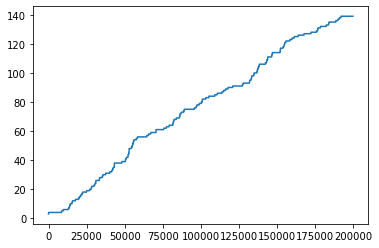

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time, chain_length)
plt.show()